<a href="https://colab.research.google.com/github/mobarakol/LTRL_Demo/blob/main/LTRL_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloading github:

In [1]:
!git clone https://github.com/mobarakol/LTRL_Demo.git
%cd LTRL_Demo

Cloning into 'LTRL_Demo'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 73 (delta 21), reused 69 (delta 20), pack-reused 0
Receiving objects: 100% (73/73), 117.11 KiB | 967.00 KiB/s, done.
Resolving deltas: 100% (21/21), done.
/content/LTRL_Demo


Downloading dataset and weights:

In [2]:
import gdown

d3k4_url = 'https://drive.google.com/uc?id=1_HrQTeZgU3AE88p1Ykawi2lkdijRNQVz'
gdown.download(d3k4_url,'d3k4.zip',quiet=True)
!unzip -q d3k4.zip
!mkdir 02
!mv -f d3k4 02/


weights_url = 'https://drive.google.com/uc?id=1YIorWkIEgx_O052kfYq9mqmJJS-Z3BnH'
gdown.download(weights_url,'af-sfmlearner.zip',quiet=True)
!unzip -q af-sfmlearner.zip -d af-sfmlearner

url = 'https://drive.google.com/uc?id=1Ajvpkim0_NQQODYHV5xloQstq9RB0bUu'
gdown.download(url,'gt_depths.npz',quiet=True)
!mv gt_depths.npz /content/LTRL_Demo/splits/endovis

Pose Estimation for Seq 02 d3k4:

In [3]:
!python evaluate_pose.py --data_path '' --eval_split endovis --load_weights_folder af-sfmlearner --batch_size 8

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
-> Computing pose predictions

   Trajectory error: 0.0500, std: 0.0280


   Rotation error: 0.0031, std: 0.0021



In [4]:
!python visualize_pose.py

Figure(640x480)


Pose trajectory visualization:

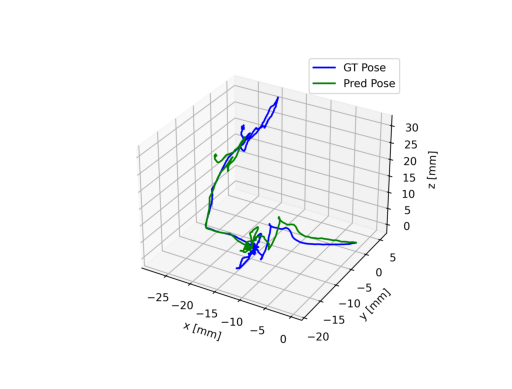

In [5]:
import matplotlib.pyplot as plt
from PIL import Image

img  = Image.open('vo_sq2.png')
plt.axis('OFF')
plt.imshow(img)

Depth for a sample frame:

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


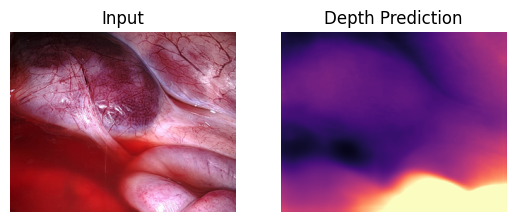

In [6]:
import datasets
from torch.utils.data import DataLoader
import torch
import numpy as np
import matplotlib.pyplot as plt

import networks
from layers import disp_to_depth


scared_dataset = datasets.SCAREDRAWDataset
with open("splits/endovis/test_files_sequence2.txt", 'r') as f:
    filenames = f.read().splitlines()

img_ext = '.jpg'
data_path = ""
height = 256
width = 320
frame_ids = [-2, -1, 0, 1, 2]
num_samples = len(filenames)

sample_dataset = scared_dataset(data_path, filenames, height, width,
    frame_ids, 4, is_train=False, img_ext=img_ext)
loader = DataLoader(
    sample_dataset, 8, True, pin_memory=True, drop_last=True)

inputs = next(enumerate(loader))
sample = inputs[1][("color_aug", -2, 0)]

device = "cuda" if torch.cuda.is_available() else "cpu"

encoder_path = "af-sfmlearner/encoder.pth"
decoder_path = "af-sfmlearner/depth.pth"
encoder_dict = torch.load(encoder_path, map_location=device)
encoder = networks.ResnetEncoder(18, False)
depth_decoder = networks.DepthDecoder(encoder.num_ch_enc, scales=range(4))

model_dict = encoder.state_dict()
encoder.load_state_dict({k: v for k, v in encoder_dict.items() if k in model_dict})
depth_decoder.load_state_dict(torch.load(decoder_path, map_location=device))

encoder.to(device)
encoder.eval()
depth_decoder.to(device)
depth_decoder.eval()
sample = sample.to(device)

output = depth_decoder(encoder(sample))
pred_disp_resized, _ = disp_to_depth(output[("disp", 0)], 1e-3, 150)
pred_disp_tensor = pred_disp_resized.cpu()[:, 0].detach()
pred_disp = pred_disp_resized.cpu()[:, 0].detach().numpy()
sample = sample.cpu()
vmax = np.percentile(pred_disp, 95)

plt.subplot(121), plt.imshow(sample[0].permute(1,2,0))
plt.axis('OFF')
plt.title('Input')

plt.subplot(122), plt.imshow(pred_disp[0], cmap='magma', vmax=vmax)
plt.axis('OFF')
plt.title('Depth Prediction');